In [1]:
import pandas as pd 

df = pd.read_csv('Airline_review.csv')

In [20]:
import re
import html

def clean_text(text):
    if not isinstance(text, str):
        return ''

    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'\(.*?\)', '', text)
    text = re.sub(r'\{.*?\}', '', text)
    text = re.sub(r'[!"\'#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF]', '', text)
    text = ''.join(char for char in text if ord(char) < 128)
    text = re.sub(r'[^a-zA-Z0-9\s@#]', '', text)
    text = re.sub(r'[\t\u00A0]', ' ', text)
    text = re.sub(r'@[^\s]+', '', text)
    text = re.sub(r'#[^\s]+', '', text)
    text = html.unescape(text)
    text = text.lower()

    return text

df['clean_text'] = df['Review'].apply(clean_text)

In [22]:
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt_tab')

df['tokens'] = df['clean_text'].apply(lambda x: word_tokenize(x))

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/joannasmietanowska/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [24]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

df['tokens_no_stopwords'] = df['tokens'].apply(lambda x: [word for word in x if word.lower() not in stop_words])


In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

df['clean_text_topics'] = df['clean_text'].fillna('')

vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(df['clean_text_topics'])

n_topics = 10
lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda_model.fit(X)

def print_topics(model, vectorizer, n_words=10):
    words = vectorizer.get_feature_names_out()
    for idx, topic in enumerate(model.components_):
        topic_words = [words[i] for i in topic.argsort()[-n_words:]]
        print(f"Topic {idx + 1}: {', '.join(topic_words)}")

print_topics(lda_model, vectorizer)

Topic 1: aircraft, food, served, friendly, service, time, cabin, crew, good, flight
Topic 2: airport, boarding, airline, bags, baggage, pay, flight, bag, check, luggage
Topic 3: flight, food, lounge, premium, lumpur, kuala, economy, service, business, class
Topic 4: airline, staff, cabin, great, friendly, crew, service, food, flight, good
Topic 5: service, change, booked, money, airline, ticket, customer, cancelled, flight, refund
Topic 6: airline, asked, row, water, crew, food, plane, flight, seats, seat
Topic 7: helpful, service, cabin, time, town, crew, cape, staff, flight, thank
Topic 8: angeles, los, pacific, que, shanghai, la, el, cathay, kong, hong
Topic 9: airport, late, airline, hour, time, plane, delay, hours, delayed, flight
Topic 10: delayed, lost, hotel, customer, luggage, airline, day, airport, hours, flight


In [35]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [37]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)

X = vectorizer.fit_transform(df['clean_text'])

n_clusters = 5 

kmeans = KMeans(n_clusters=n_clusters, random_state=42)

df['cluster'] = kmeans.fit_predict(X)

tsne = TSNE(n_components=2, random_state=42)

X_tsne = tsne.fit_transform(X.toarray())

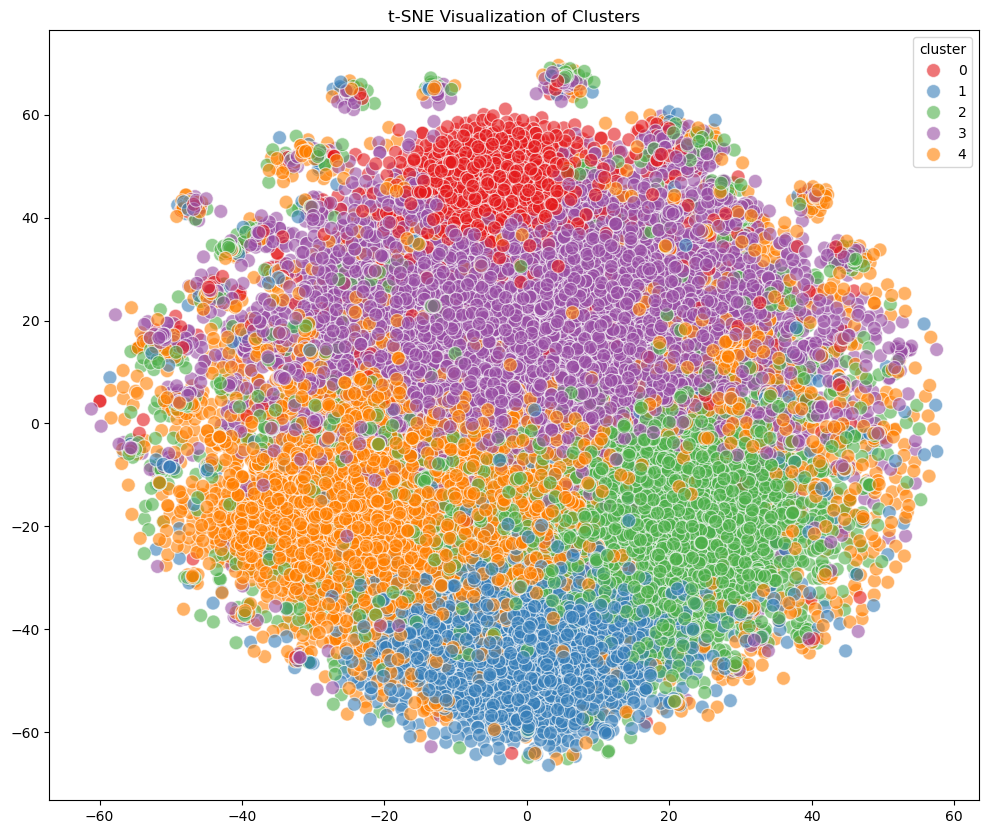

None


In [39]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=df['cluster'], palette='Set1', s=100, alpha=0.6)
plt.title("t-SNE Visualization of Clusters")
print(plt.show())

In [40]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

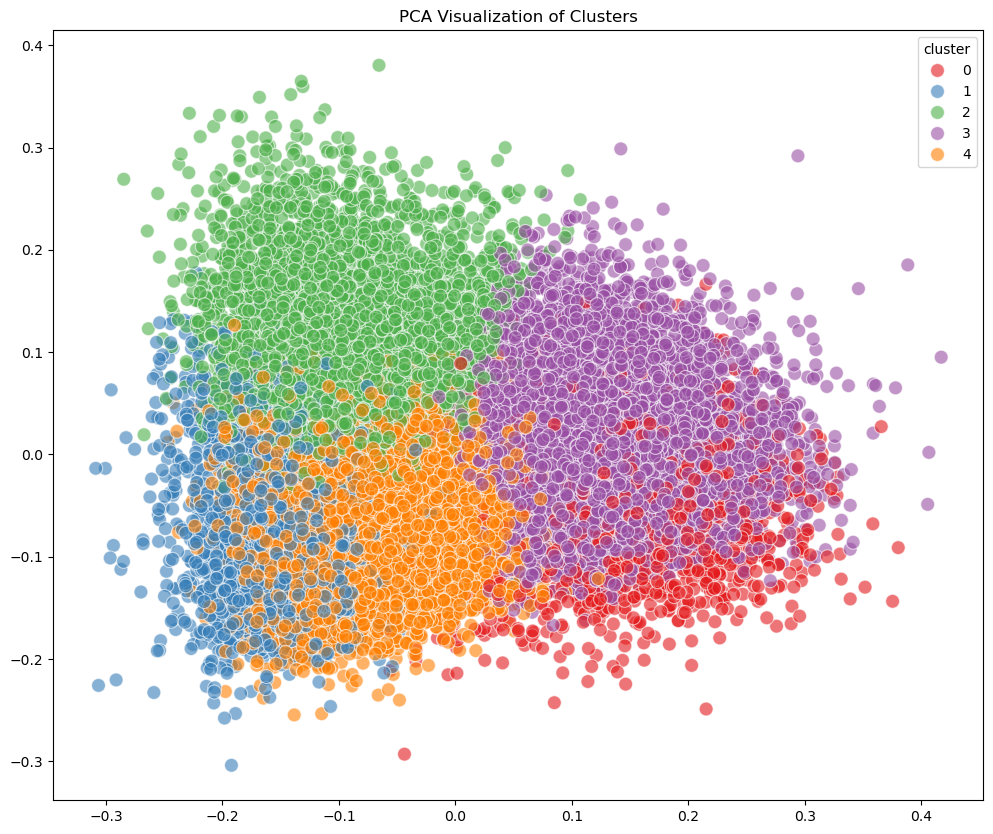

None


In [41]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['cluster'], palette='Set1', s=100, alpha=0.6)
plt.title("PCA Visualization of Clusters")
print(plt.show())

In [42]:
terms = vectorizer.get_feature_names_out()

top_words = 10 
order_centroids = kmeans.cluster_centers_.argsort() 

for cluster_num in range(n_clusters):
    print(f"\nCluster {cluster_num} Keywords:")
    top_terms = [terms[i] for i in order_centroids[cluster_num, ::-1][:top_words]]
    print(", ".join(top_terms))


top_words = 20
components = pca.components_

for component_num, component in enumerate(components):
    print(f"\nPCA Component {component_num} Keywords:")
    top_terms_idx = component.argsort()[-top_words:][::-1]
    top_terms = [terms[i] for i in top_terms_idx]
    print(", ".join(top_terms))



Cluster 0 Keywords:
class, business, economy, flight, seats, food, service, seat, good, lounge

Cluster 1 Keywords:
refund, flight, cancelled, customer, ticket, airline, email, money, service, booked

Cluster 2 Keywords:
flight, hours, delayed, airport, time, delay, airline, plane, hour, told

Cluster 3 Keywords:
flight, good, crew, cabin, food, service, time, friendly, seats, staff

Cluster 4 Keywords:
luggage, airline, flight, bag, service, check, pay, staff, baggage, customer

PCA Component 0 Keywords:
good, crew, cabin, food, friendly, class, comfortable, seats, seat, aircraft, clean, nice, business, excellent, great, entertainment, economy, served, drinks, meal

PCA Component 1 Keywords:
flight, hours, delayed, time, plane, hour, delay, minutes, airport, late, gate, arrived, passengers, boarding, departure, crew, hotel, connecting, day, left
